In [209]:
# Imports
import json
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
import pandas as pd

In [210]:
# ---------------------------
# DATASET
# ---------------------------

df = pd.read_csv("data/edges.csv")
print(df.head())

df_first_7_days = pd.read_csv("data/edges_first_7_days.csv")
df_8_21_days = pd.read_csv("data/edges_8_21_days.csv")
df_22_plus_days = pd.read_csv("data/edges_22_plus_days.csv")

agencies = df["source"].unique()
reports = df["target"].unique()

print(f"Agencies: {len(agencies)}") 
print(f"Reports: {len(reports)}")

with open("data/organisations_with_types_reassigned.json", "r", encoding="utf-8") as f:
    roles_data = json.load(f)

   source   target
0    1979  3105338
1    1212  3105338
2    1051  3105338
3    3594  3105113
4    2591  3105113
Agencies: 105
Reports: 192


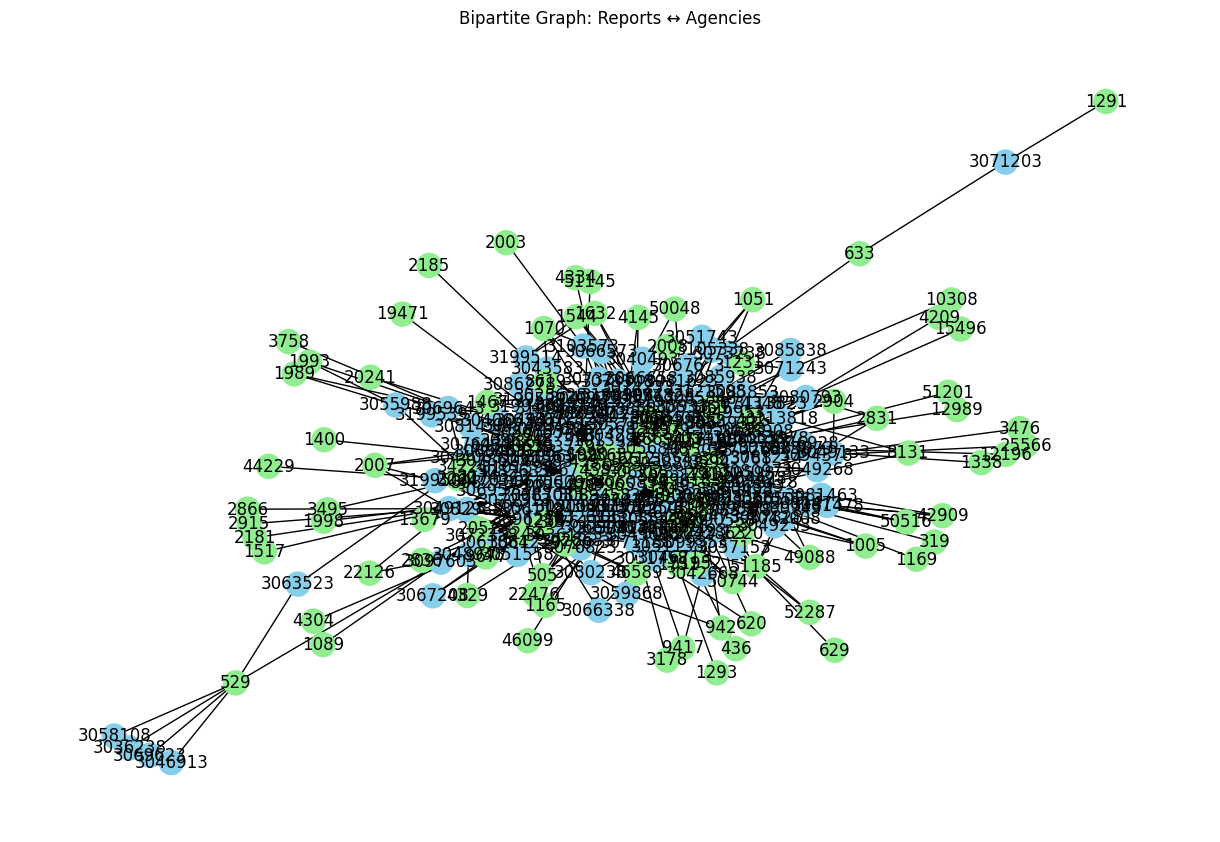

In [211]:
# ---------------------------
# Part 4: Bipartite Graph Creation
# ---------------------------

# Create bipartite graph
B = nx.Graph()

# Add edges from DataFrame
B.add_nodes_from(reports, bipartite=0)  # Set 0: Reports
B.add_nodes_from(agencies, bipartite=1)  # Set 1: Agencies
B.add_edges_from(df.values)

# Visualize bipartite graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(B, seed=42)
colors = ["skyblue" if node in reports else "lightgreen" for node in B.nodes()]
nx.draw(B, pos, with_labels=True, node_color=colors)
plt.savefig("figures/bipartiteGraph.png")
plt.title("Bipartite Graph: Reports ↔ Agencies")
plt.show()

nx.write_gexf(B, "analysis-output/bipartite_graph.gexf")

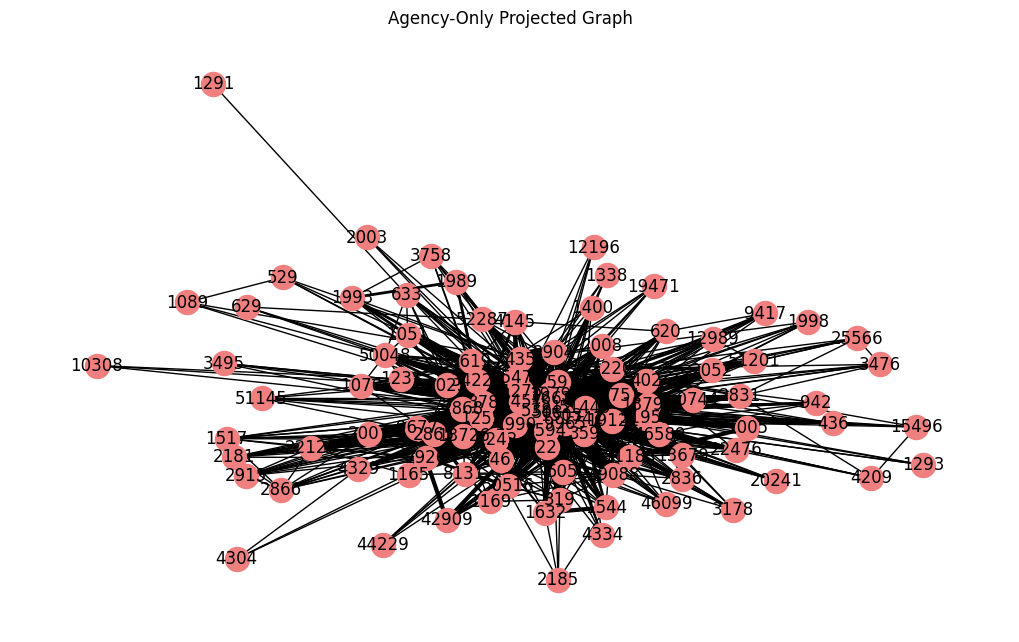

In [212]:
# ---------------------------
# Part 5: Projected Agency Graph
# ---------------------------

# Project to agency-only graph
agency_proj = bipartite.weighted_projected_graph(B, agencies)

# Visualize weighted agency graph
plt.figure(figsize=(10, 6))
edge_weights = [agency_proj[u][v]["weight"] for u, v in agency_proj.edges()]
pos = nx.spring_layout(agency_proj)
nx.draw(agency_proj, with_labels=True, width=edge_weights, node_color="lightcoral")
plt.savefig("figures/agencyGraphProjected.png")
plt.title("Agency-Only Projected Graph")
plt.show()


Academic and Research Institution


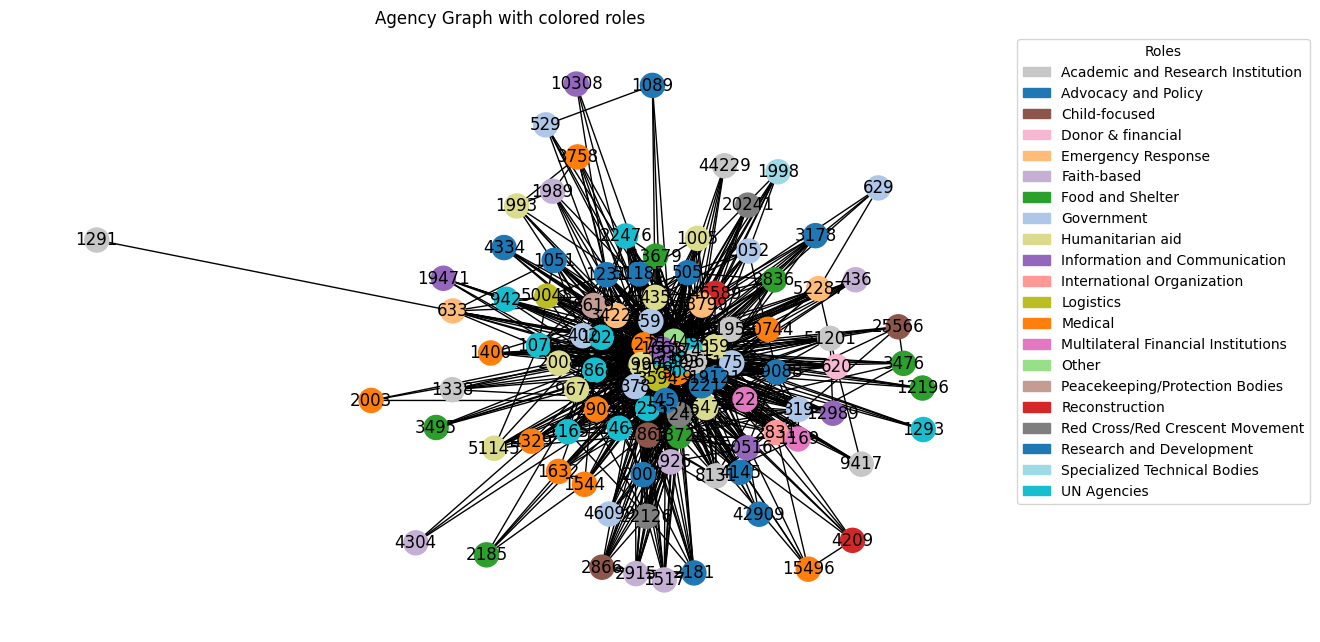

In [213]:
# ---------------------------
# Part 6: Assigning Roles to Agencies
# ---------------------------

roled_agency_proj = agency_proj.copy()
# Iterate nodes
for node in roled_agency_proj.nodes():
    if str(node) == "9417":
        print(roles_data.get(str(node))["type"]["name"])
    roled_agency_proj.nodes()[node]["role"] = roles_data.get(str(node))["type"]["name"]

# Check for missing roles
missing_roles = [n for n in roled_agency_proj.nodes() if "role" not in roled_agency_proj.nodes[n]]
if missing_roles:
    print("Warning: These agencies have no assigned role:", missing_roles)
    print(len(missing_roles), "agencies have no assigned role.")


# Unique roles 
unique_roles = set(roled_agency_proj.nodes[n]["role"] for n in roled_agency_proj.nodes())
"""
print("Unique roles:")
for role in unique_roles:
    print(" - " + role)
"""
# Create role-color mapping 

role_color_map = {role: color for role, color in zip(unique_roles, plt.cm.tab20.colors + plt.cm.tab20.colors)}
# Sort
role_color_map = dict(sorted(role_color_map.items(), key=lambda item: item[0]))
# Assign colors to nodes based on roles 
for node in roled_agency_proj.nodes():
    role = roled_agency_proj.nodes()[node]["role"]
    roled_agency_proj.nodes()[node]["color"] = role_color_map.get(role, "gray")  # Default to gray if role not found


# Visualize agency graph with roles
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(roled_agency_proj)
colors = [roled_agency_proj.nodes()[node]["color"] for node in roled_agency_proj.nodes()]
nx.draw(roled_agency_proj, pos, with_labels=True, node_color=colors)

handles = []
for role, color in role_color_map.items():
    handles.append(plt.Circle([0], [0], color=color, label=role))
plt.legend(handles=handles, title="Roles", loc="upper left", bbox_to_anchor=(1, 1))

plt.title("Agency Graph with colored roles")
plt.axis("off")  # Hide axes
plt.show()

# Graph not gephi compatible, cannot export

In [214]:

# ---------------------------
# Part 7: Centrality Measures
# ---------------------------
degree_centrality = nx.degree_centrality(agency_proj)
betweenness_centrality = nx.betweenness_centrality(agency_proj)
closeness_centrality = nx.closeness_centrality(agency_proj)
eigenvector_centrality = nx.eigenvector_centrality(agency_proj)

# Display top agencies by centrality
print("\n--- Centrality Measures ---")
print("Top 5 by Degree Centrality:") 
top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
for agency, centrality in top_degree:
    print(f"{agency}: {centrality:.4f}")
print("\nTop 5 by Betweenness Centrality:")
top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
for agency, centrality in top_betweenness:
    print(f"{agency}: {centrality:.4f}")
print("\nTop 5 by Closeness Centrality:")
top_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
for agency, centrality in top_closeness:
    print(f"{agency}: {centrality:.4f}")
print("\nTop 5 by Eigenvector Centrality:")
top_eigenvector = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
for agency, centrality in top_eigenvector:
    print(f"{agency}: {centrality:.4f}")


# TODO: Visualize top-ranking agencies or summarize findings in a table. Highlight which agencies serve as bridges or hubs in the network


--- Centrality Measures ---
Top 5 by Degree Centrality:
1212: 0.8365
538: 0.8077
508: 0.7885
1663: 0.7115
1275: 0.6442

Top 5 by Betweenness Centrality:
1212: 0.1292
538: 0.1112
508: 0.1020
1663: 0.0836
1275: 0.0618

Top 5 by Closeness Centrality:
1212: 0.8595
538: 0.8387
508: 0.8254
1663: 0.7761
1275: 0.7376

Top 5 by Eigenvector Centrality:
1212: 0.2272
538: 0.2261
508: 0.2249
1663: 0.2031
1741: 0.2013


In [215]:
# ---------------------------
# Part 8: Role Assortativity
# ---------------------------
assortativity = nx.attribute_assortativity_coefficient(roled_agency_proj, "role")
print(f"\nRole Assortativity Coefficient: {assortativity:.3f}")


Role Assortativity Coefficient: -0.018



Number of communities detected: 4


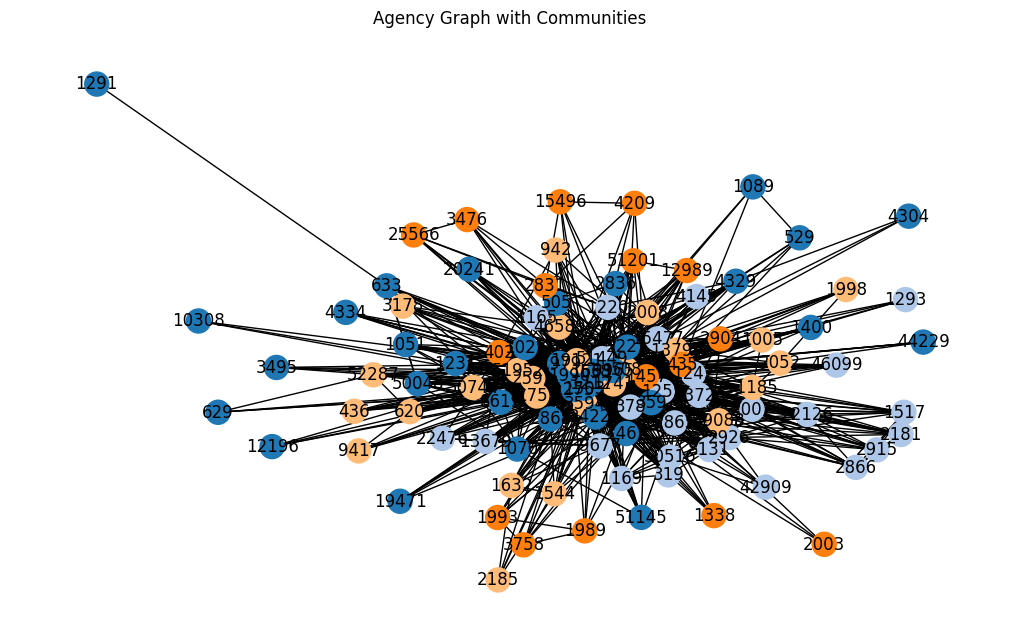

In [216]:
# ---------------------------
# Part 9: Community Detection (Greedy modular)
# ---------------------------

community_agency_proj = agency_proj.copy()

c = nx.algorithms.community.louvain_communities(community_agency_proj)
print(f"\nNumber of communities detected: {len(c)}")
# Color communities 
community_colors = [plt.cm.tab20(i) for i in range(len(c))]
# Create a mapping from node to community
node_to_community = {}
for i, community in enumerate(c):
    for node in community:
        node_to_community[node] = i
# Assign colors to nodes based on community
for node in community_agency_proj.nodes():
    community_agency_proj.nodes()[node]["community"] = node_to_community[node]
# Visualize communities with each being clearly seperated
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(community_agency_proj)
# Assign colors to nodes based on community
for node in community_agency_proj.nodes():
    community_agency_proj.nodes()[node]["color"] = community_colors[community_agency_proj.nodes()[node]["community"]]
colors = [community_agency_proj.nodes()[node]["color"] for node in community_agency_proj.nodes()]
nx.draw(community_agency_proj, pos, with_labels=True, node_color=colors)
plt.title("Agency Graph with Communities")
plt.show()

# TODO: Label and interpret these clusters e.g., regional coordination bodies or logistics hubs


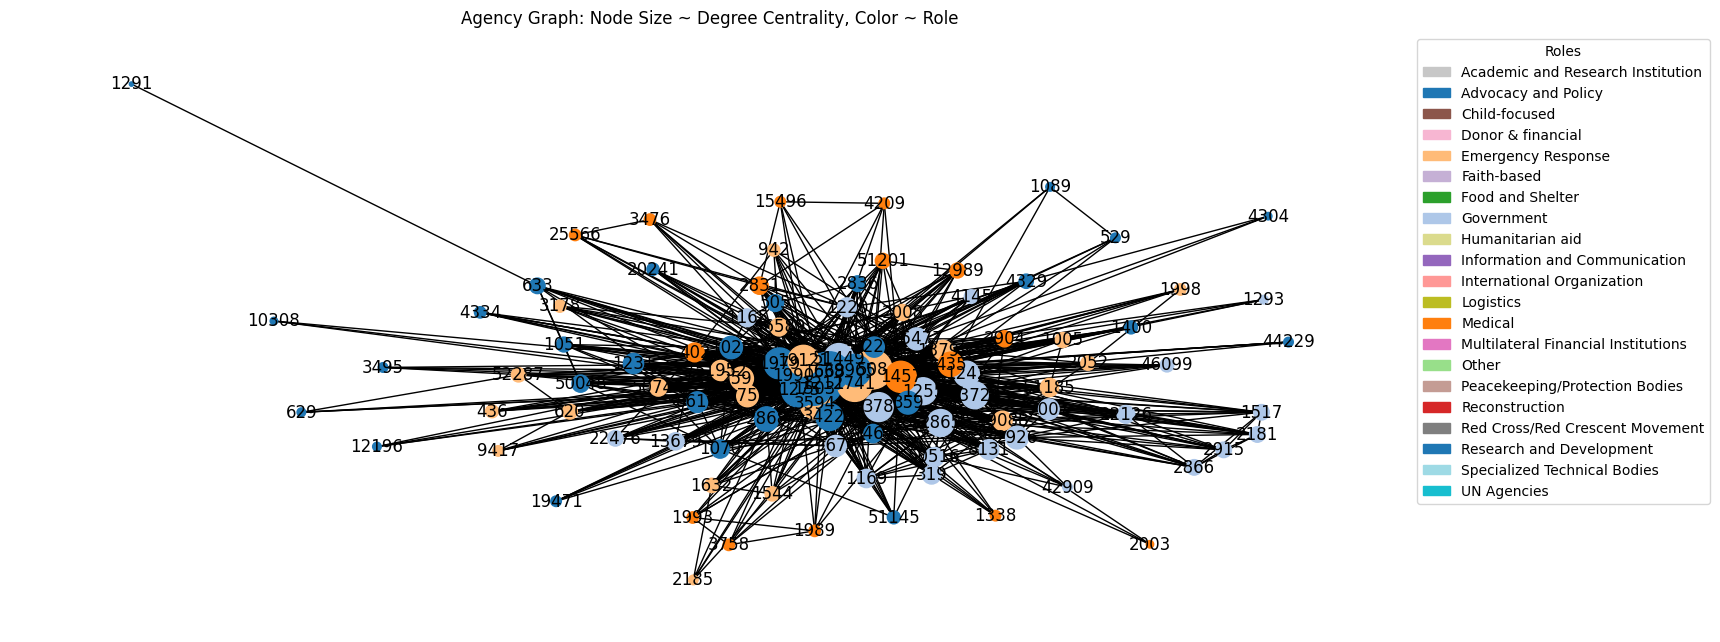

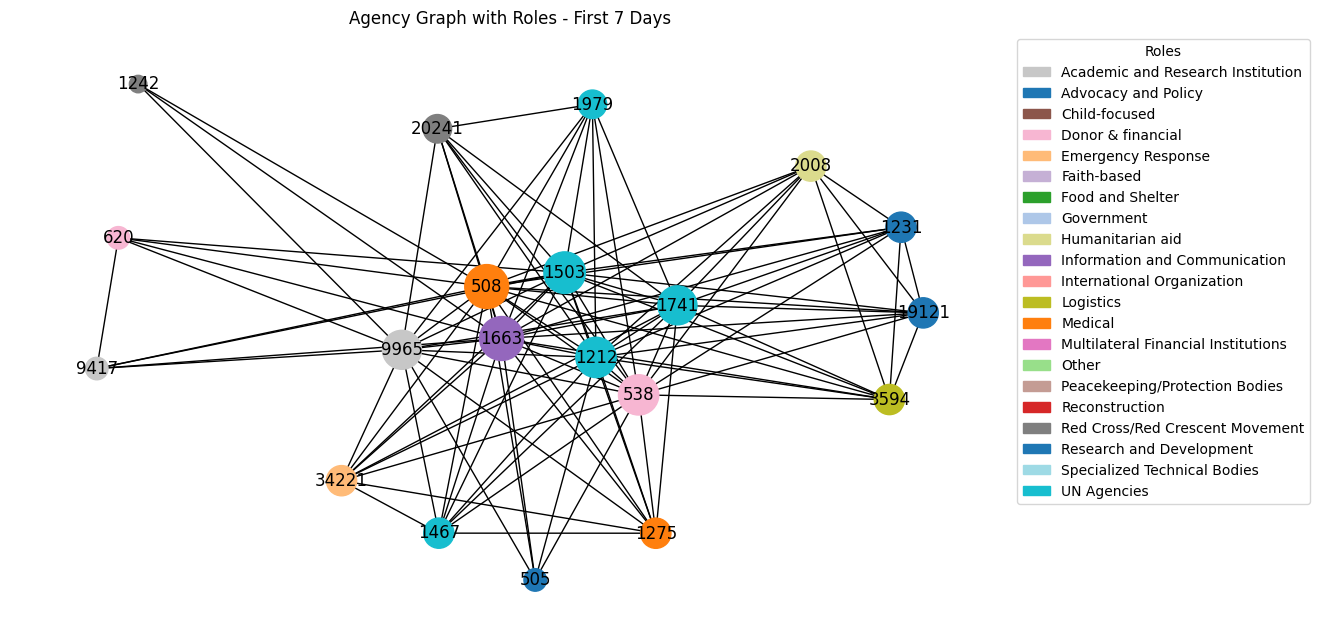

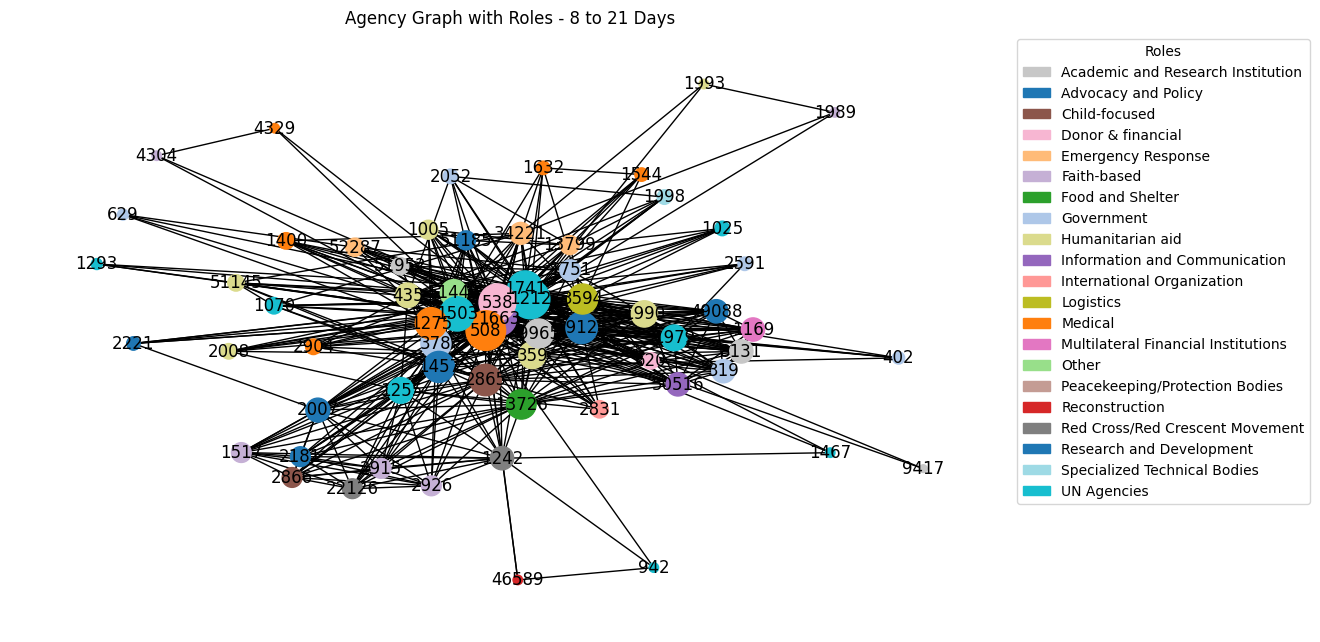

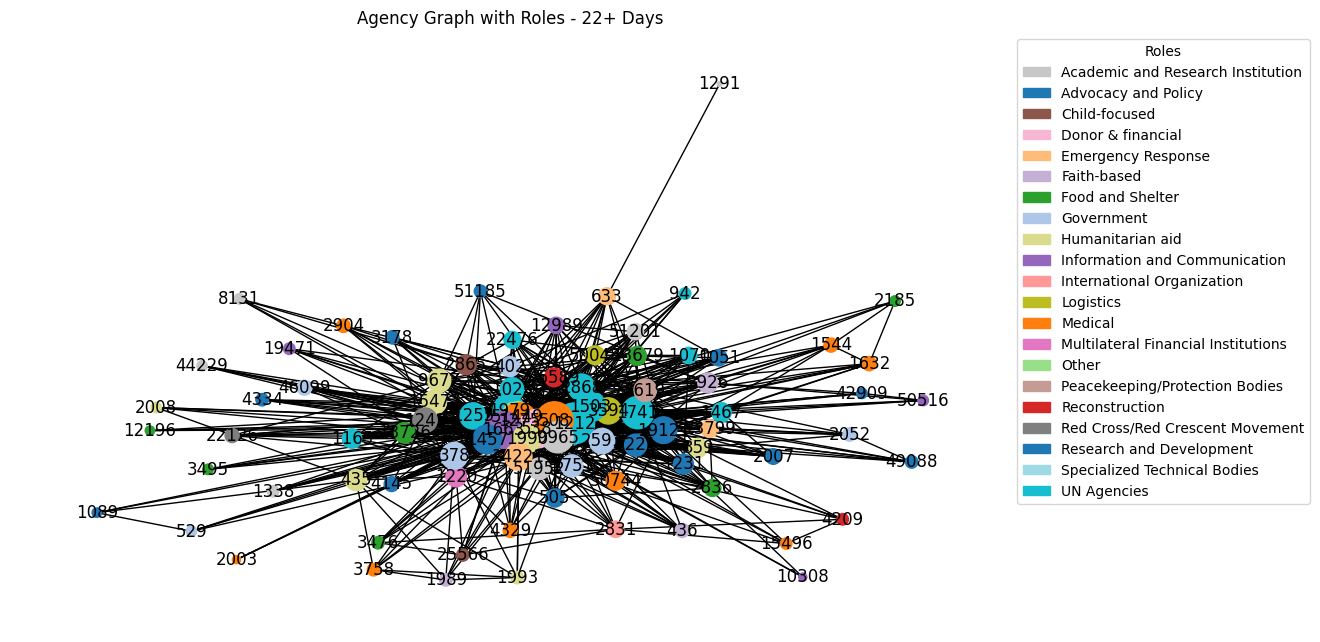

In [217]:
# ---------------------------
# Part 11: Enhanced Visalization
# ---------------------------

# --- Visualization with Centrality and Role ---
plt.figure(figsize=(14, 6))

# Node size based on degree centrality (scaled)
sizes = [1000 * degree_centrality[node] for node in community_agency_proj.nodes()]

colors_by_role = [community_agency_proj.nodes()[node]["color"] for node in community_agency_proj.nodes()]

nx.draw(community_agency_proj, pos, with_labels=True, node_size=sizes, node_color=colors_by_role)
plt.title("Agency Graph: Node Size ~ Degree Centrality, Color ~ Role")
handles = []
for role, color in role_color_map.items():
    handles.append(plt.Circle([0], [0], color=color, label=role))
plt.legend(handles=handles, title="Roles", loc="upper left", bbox_to_anchor=(1, 1))
plt.savefig("figures/enhanced_visualization.png")
plt.show()

edge_files = {
    "First 7 Days": df_first_7_days,
    "8 to 21 Days": df_8_21_days,
    "22+ Days": df_22_plus_days
}

for title, df in edge_files.items():
    G = nx.Graph()
    agencies_timeframe = df["source"].unique()
    reports_timeframe = df["target"].unique()
    G.add_nodes_from(reports_timeframe, bipartite=0)  # Set 0: Reports
    G.add_nodes_from(agencies_timeframe, bipartite=1)  # Set 1: Agencies
    G.add_edges_from(df.values)

    # Project to agency-only graph 
    agency_proj_timeframe = bipartite.weighted_projected_graph(G, agencies_timeframe)
    # Remove isolated nodes
    agency_proj_timeframe.remove_nodes_from(list(nx.isolates(agency_proj_timeframe)))

    # Degree centrality
    degree_centrality_timeframe = nx.degree_centrality(agency_proj_timeframe)

    # Increase node size based on degree centrality 
    sizes = [1000 * degree_centrality_timeframe[node] for node in agency_proj_timeframe.nodes()]

    # Assign roles
    for node in agency_proj_timeframe.nodes():
        agency_proj_timeframe.nodes()[node]["role"] = roles_data.get(str(node), {}).get("type", {}).get("name", "Unknown")

    # Assign colors to nodes based on roles 
    for node in agency_proj_timeframe.nodes():
        role = agency_proj_timeframe.nodes()[node]["role"]
        agency_proj_timeframe.nodes()[node]["color"] = role_color_map.get(role, "gray")

    # Create a color map for the nodes based on roles
    colors = [agency_proj_timeframe.nodes()[node]["color"] for node in agency_proj_timeframe.nodes()]

    # Visualize agency graph with roles
    plt.figure(figsize=(10, 6))
    pos_timeframe = nx.spring_layout(agency_proj_timeframe)
    nx.draw(agency_proj_timeframe, pos_timeframe, with_labels=True, node_size=sizes, node_color=colors)
    plt.title(f"Agency Graph with Roles - {title}")
    plt.axis("off")  # Hide axes

    # Add legend for roles
    handles = []
    for role, color in role_color_map.items():
        handles.append(plt.Circle([0], [0], color=color, label=role))
    plt.legend(handles=handles, title="Roles", loc="upper left", bbox_to_anchor=(1, 1))

    plt.savefig(f"figures/agencyGraphWithRoles_{title}.png")
    plt.show()



# TODO: Different phases visualization (use the split datasets)

SIMULATING FAILURE FOR GRAPH: with roles
Top 3 central agencies for removal:
 - 1212: 0.1292
 - 538: 0.1112
 - 508: 0.1020

--- Network Metrics (Before Node Removal) ---
Connected Components: 1
Average Shortest Path Length: 1.8294871794871794
Diameter: 3

--- Network Metrics (After Node Removal) ---
Connected Components: 1
Average Shortest Path Length: 1.9466123082896525
Diameter: 4


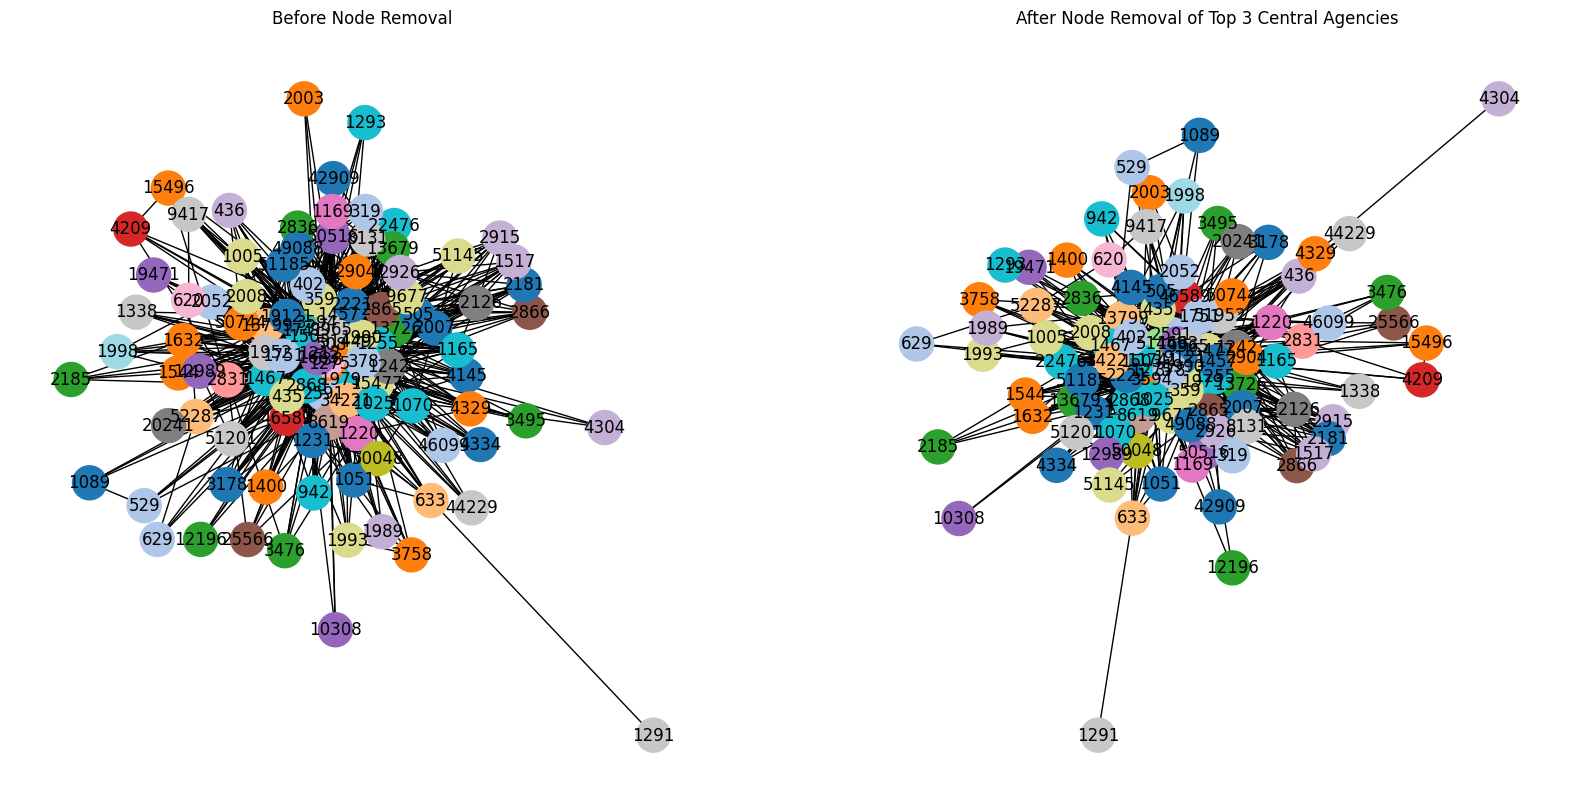

SIMULATING FAILURE FOR GRAPH: First 7 Days
Top 3 central agencies for removal:
 - 508: 0.1020
 - 1663: 0.0836
 - 1503: 0.0408

--- Network Metrics (Before Node Removal) ---
Connected Components: 1
Average Shortest Path Length: 1.436842105263158
Diameter: 2

--- Network Metrics (After Node Removal) ---
Connected Components: 1
Average Shortest Path Length: 1.6838235294117647
Diameter: 3


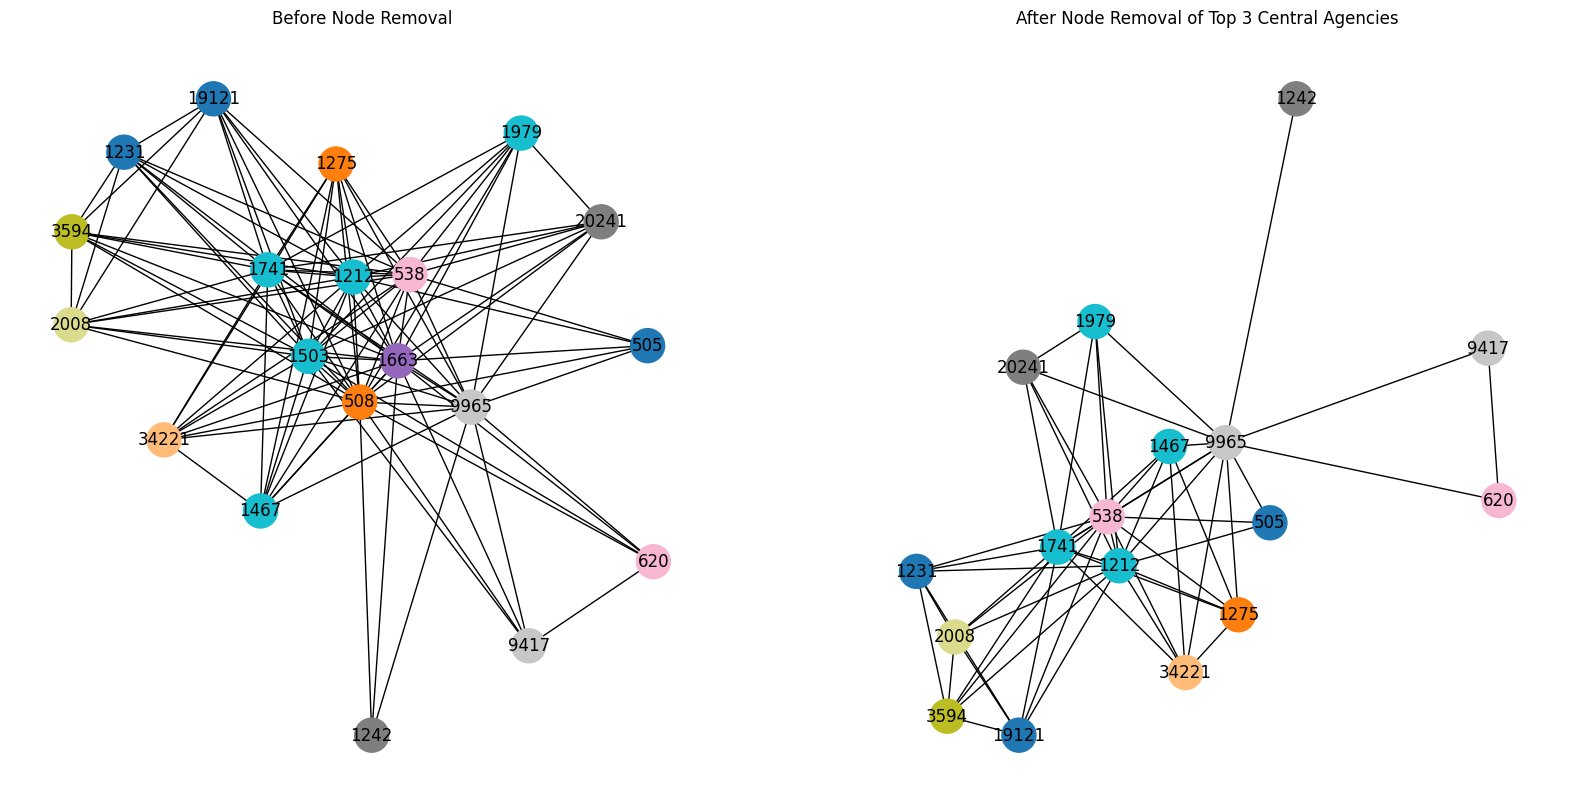

SIMULATING FAILURE FOR GRAPH: 8 to 21 Days
Top 3 central agencies for removal:
 - 508: 0.1020
 - 1212: 0.1292
 - 538: 0.1112

--- Network Metrics (Before Node Removal) ---
Connected Components: 1
Average Shortest Path Length: 1.7769230769230768
Diameter: 3

--- Network Metrics (After Node Removal) ---
Connected Components: 2
Average Shortest Path Length: 1.9429378531073447
Diameter: 4


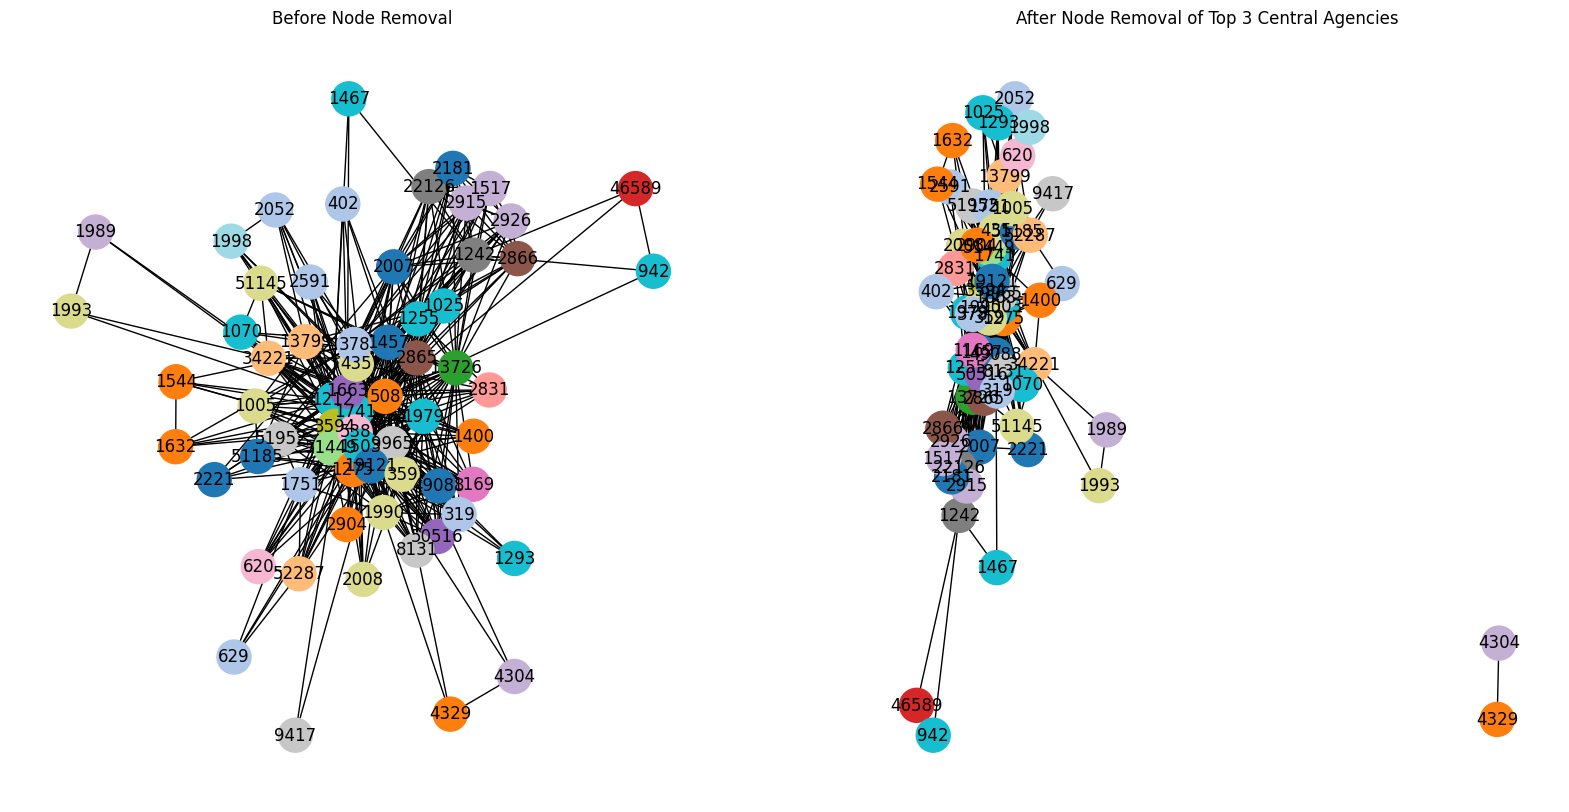

SIMULATING FAILURE FOR GRAPH: 22+ Days
Top 3 central agencies for removal:
 - 1212: 0.1292
 - 538: 0.1112
 - 1663: 0.0836

--- Network Metrics (Before Node Removal) ---
Connected Components: 1
Average Shortest Path Length: 1.8273249738766981
Diameter: 3

--- Network Metrics (After Node Removal) ---
Connected Components: 1
Average Shortest Path Length: 1.9719887955182074
Diameter: 4


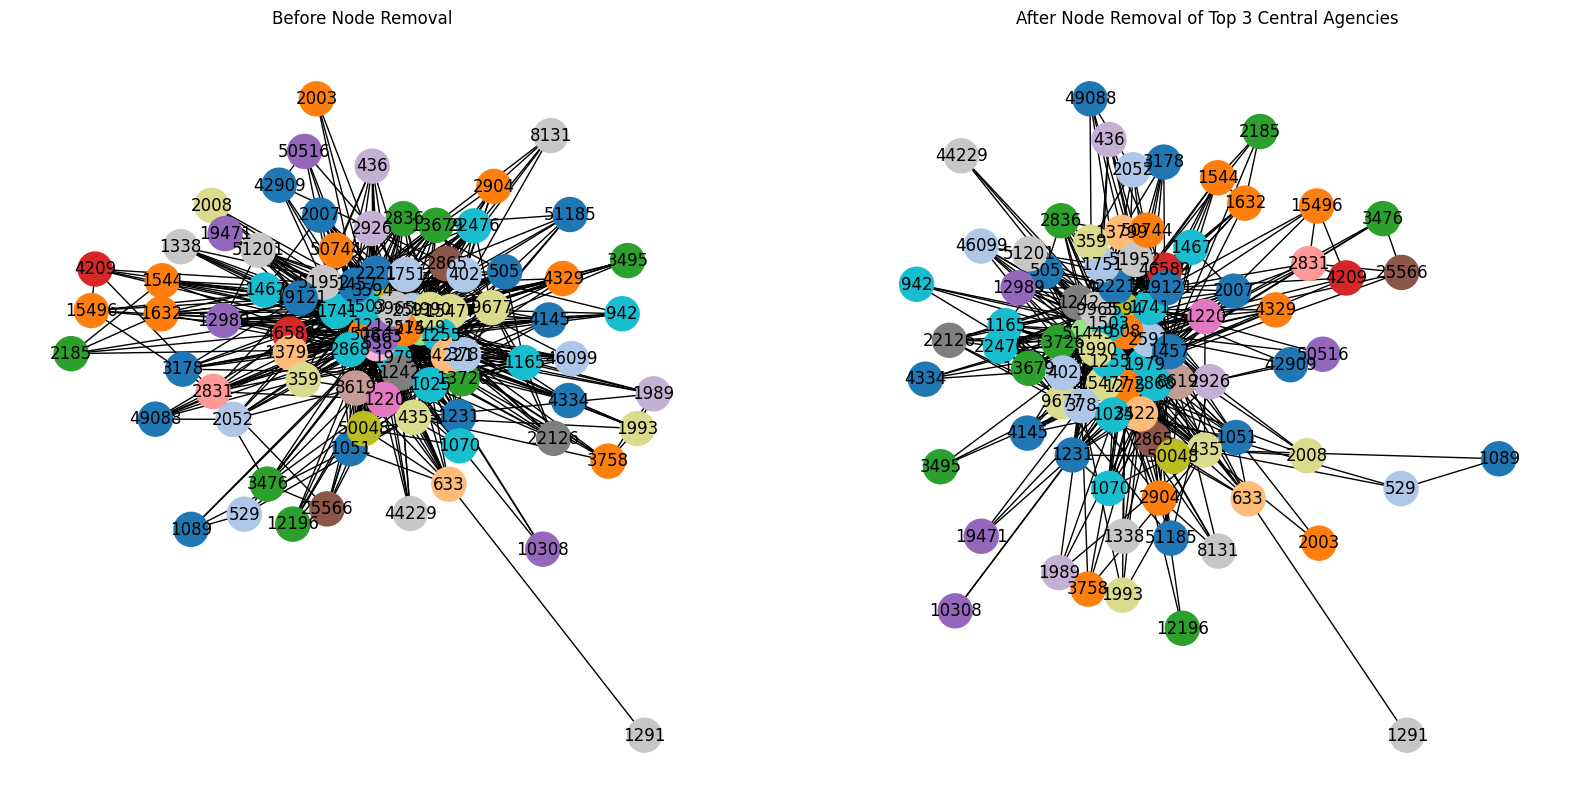

In [218]:
# ---------------------------
# Part 12: Failure Simulation of Central Nodes
# ---------------------------
def failure_simulation(G, name):
    """
    Simulate the failure of nodes in the network.
    """

    print("SIMULATING FAILURE FOR GRAPH: " + name)

    failure_simulation = G.copy()
    betweenness_centrality_fs = nx.betweenness_centrality(failure_simulation)

    # Identify top 3 agencies by betweenness centrality
    top_3_nodes = [node for node, _ in sorted(betweenness_centrality_fs.items(), key=lambda x: x[1], reverse=True)[:3]]
    print("Top 3 central agencies for removal:")
    for node in top_3_nodes:
        print(f" - {node}: {betweenness_centrality[node]:.4f}")

    # Function to compute and display network metrics
    def compute_network_metrics(G, label=""):
        metrics = {
            "Connected Components": nx.number_connected_components(G),
            "Average Shortest Path Length": None,
            "Diameter": None
        }
        if nx.is_connected(G):
            metrics["Average Shortest Path Length"] = nx.average_shortest_path_length(G)
            metrics["Diameter"] = nx.diameter(G)
        else:
            largest_cc = max(nx.connected_components(G), key=len)
            subgraph = G.subgraph(largest_cc)
            metrics["Average Shortest Path Length"] = nx.average_shortest_path_length(subgraph)
            metrics["Diameter"] = nx.diameter(subgraph)

        print(f"\n--- Network Metrics {label} ---")
        for k, v in metrics.items():
            print(f"{k}: {v}")
        return metrics

    # Compute metrics BEFORE removal
    compute_network_metrics(failure_simulation, label="(Before Node Removal)")

    # Assign roles to nodes
    for node in failure_simulation.nodes():
        failure_simulation.nodes()[node]["role"] = roles_data[str(node)]["type"]["name"]

    # Assign colors to nodes based on roles
    for node in failure_simulation.nodes():
        role = failure_simulation.nodes()[node]["role"]
        failure_simulation.nodes()[node]["color"] = role_color_map.get(role, "gray")
    # Create a color map for the nodes based on roles
    colors_by_role_fs = [failure_simulation.nodes()[node]["color"] for node in failure_simulation.nodes()]

    # Clone and remove top nodes
    failure_simulation_removed = failure_simulation.copy()
    failure_simulation_removed.remove_nodes_from(top_3_nodes)
    # Assign colors to nodes based on roles
    for node in failure_simulation_removed.nodes():
        role = failure_simulation_removed.nodes()[node]["role"]
        failure_simulation_removed.nodes()[node]["color"] = role_color_map.get(role, "gray")
    # Create a color map for the nodes based on roles
    colors_removed = [failure_simulation_removed.nodes()[node]["color"] for node in failure_simulation_removed.nodes()]
    f


    # Compute metrics AFTER removal
    compute_network_metrics(failure_simulation_removed, label="(After Node Removal)")

    # Compute positions for visualization
    pos_before = nx.spring_layout(failure_simulation, seed=42)
    pos_removed = nx.spring_layout(failure_simulation_removed, seed=42)

    # Visualize BEFORE and AFTER removal in the same plot
    plt.figure(figsize=(20, 10))

    # BEFORE removal
    plt.subplot(1, 2, 1)
    nx.draw(failure_simulation, pos_before, with_labels=True, node_size=600, node_color=colors_by_role_fs)
    plt.title("Before Node Removal")

    # AFTER removal
    plt.subplot(1, 2, 2)
    nx.draw(failure_simulation_removed, pos_removed, with_labels=True, node_size=600, node_color=colors_removed)
    plt.title("After Node Removal of Top 3 Central Agencies")

    # Save the combined plot
    plt.savefig("figures/failure_simulation_comparison.png")
    plt.show()


# Simulate failure for the roled agency graph
failure_simulation(roled_agency_proj, "with roles")
# Simulate failure for the time frame-specific agency graphs 
for title, df in edge_files.items():
    G = nx.Graph()
    G.add_nodes_from(reports, bipartite=0)  # Set 0: Reports
    G.add_nodes_from(agencies, bipartite=1)  # Set 1: Agencies
    G.add_edges_from(df.values)

    # Project to agency-only graph 
    agency_proj_timeframe = bipartite.weighted_projected_graph(G, agencies)
    # Remove isolated nodes
    agency_proj_timeframe.remove_nodes_from(list(nx.isolates(agency_proj_timeframe)))

    # Simulate failure 
    failure_simulation(agency_proj_timeframe, title)

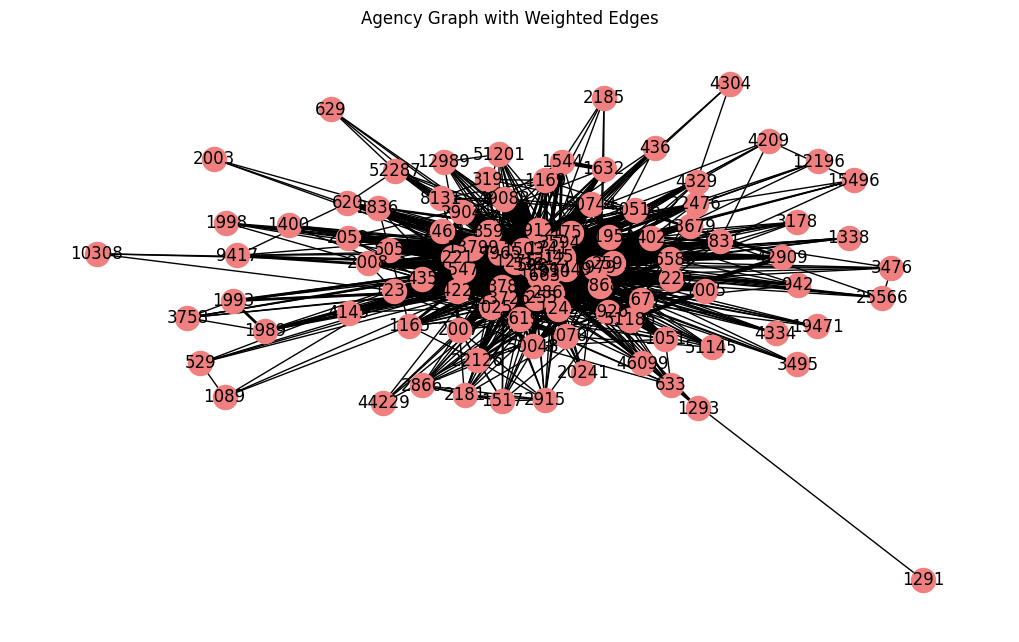

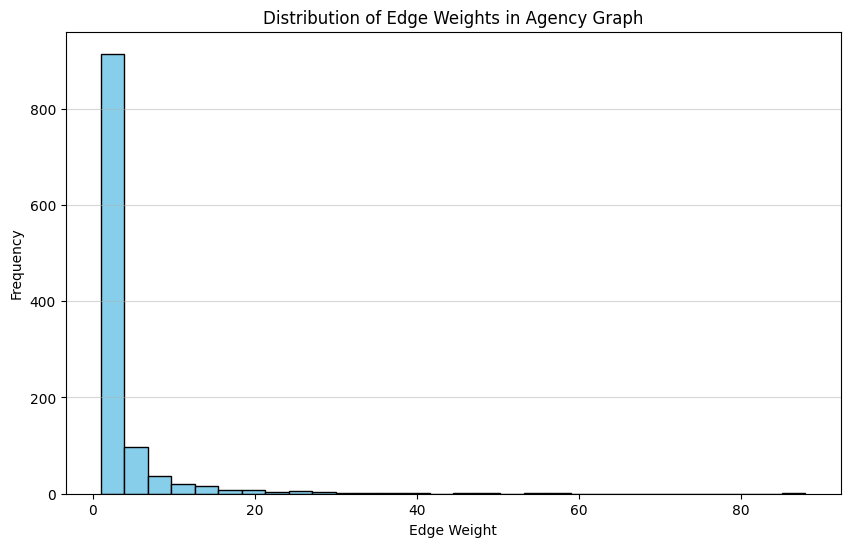

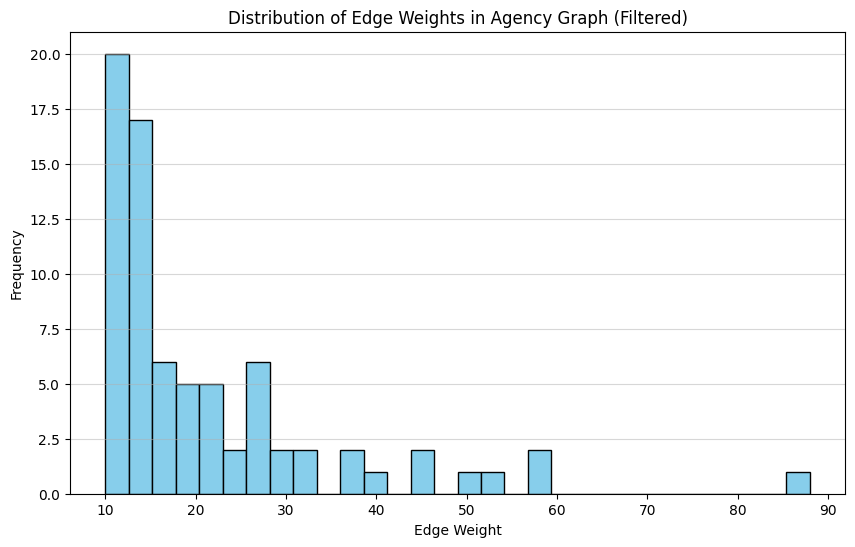

In [219]:
# ---------------------------
# Part 13: Weighted edges
# ---------------------------

# Visualize the original agency graph with weighted edges
plt.figure(figsize=(10, 6))
edge_weights = [agency_proj[u][v]["weight"] for u, v in agency_proj.edges()]

pos = nx.spring_layout(agency_proj)
nx.draw(agency_proj, pos, with_labels=True, width=edge_weights, node_color="lightcoral")
plt.title("Agency Graph with Weighted Edges")
plt.axis("off")  # Hide axes
plt.savefig("figures/agencyGraphWeighted.png")
plt.show()

# Visualize weight distribution 
plt.figure(figsize=(10, 6))
plt.hist(edge_weights, color='skyblue', edgecolor='black', bins=30)
plt.title("Distribution of Edge Weights in Agency Graph")
plt.xlabel("Edge Weight")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.5)
plt.savefig("figures/edgeWeightDistribution.png")
plt.show()

# Weights visualized with smaller than 10 values removed (for clarity)
plt.figure(figsize=(10, 6))
edge_weights_filtered = [weight for weight in edge_weights if weight >= 10]
plt.hist(edge_weights_filtered, color='skyblue', edgecolor='black', bins=30)
plt.title("Distribution of Edge Weights in Agency Graph (Filtered)")
plt.xlabel("Edge Weight")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.5)
plt.savefig("figures/edgeWeightDistributionFiltered.png")
plt.show()